# OkNLP

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import warnings


import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
from utils.categorize_demographics import *
from utils.clean_up import clean_up
#from utils.distinctive_tokens import log_odds_ratio



In [31]:
from utils.nonnegative_matrix_factorization import nmf_labels, nmf_inspect
from utils.plotting import lollipop_paper
from utils.splits import *
from utils.text_representation import feature_vectors
%matplotlib inline

In [3]:
from utils.lexical_features import *

In [4]:
import seaborn as sns

In [8]:
df = pd.read_csv('data/profiles.csv')
df.columns.values

array(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education',
       'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5',
       'essay6', 'essay7', 'essay8', 'essay9', 'ethnicity', 'height',
       'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes',
       'speaks', 'status'], dtype=object)

In [9]:
must_haves = ['body_type', 'height', 'education', 'ethnicity', 'sex', 'essay0']
print(len(df))
df = df.dropna(subset= must_haves)
print(len(df))


60552
41668


In [10]:
#Keep only men
df= df[df['sex']=="m"]
len(df)

25281

In [35]:
df.to_csv('okcupid_filtered.csv')

In [36]:
def recode(text, dictionary, default=np.nan):
    '''Function for recoding categories in a column based on exact matches'''
    out = default
    text = str(text)
    
    for x in dictionary.keys():
        for y in dictionary[x]:
            if y == text: #exact match
                out = x
                return out
    return out

In [38]:
##Recoding the data
# education
ed_levels = {'HS_or_less': ['dropped out of high school', 'working on high school','graduated from high school', 'working on college/university', 
                    'two-year college', 'dropped out of college/university', 
                    'high school'], 
             'more_than_HS': ['graduated from college/university', 
                    'working on masters program', 'working on ph.d program', 
                    'college/university', 'working on law school', 
                    'dropped out of masters program', 
                    'dropped out of ph.d program', 'dropped out of law school', 
                    'dropped out of med school',
                    'graduated from masters program',
                    'graduated from ph.d program',                           
                    'graduated from law school', 
                    'graduated from med school', 'masters program', 
                    'ph.d program', 'law school', 'med school']}

#body type
bodies = {'fit': ['fit', 'athletic', 'jacked'], 
          'not_fit': ['average', 'thin', 'skinny','curvey', 'a little extra', 
                      'full figured', 'overweight', 'rather not say', 'used up']
         }


In [39]:
df['edu'] = df.education.apply(recode, dictionary=ed_levels, 
                                            default='unknown')
df['fitness_level'] = df.body_type.apply(recode, dictionary=bodies, 
                                            default='unknown')

In [14]:
#height
df['height'] = pd.to_numeric(df['height'], errors = 'ignore')

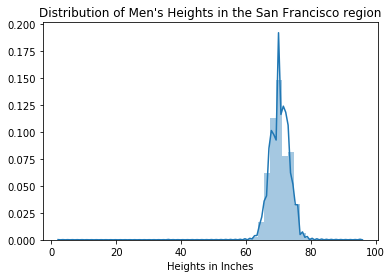

In [15]:
#df['height'].hist(bins=15
ax = sns.distplot(df['height'], 
                  axlabel= "Heights in Inches" ).set_title("Distribution of Men's Heights in the San Francisco region")

In [16]:
def height_check(inches):
    h = 'not_short'
    if inches <= 66:
        h = 'short'
    return h

df['height_group'] = df.height.apply(height_check)
df[['height', 'height_group']]

,height,height_group
0,75.0,not_short
1,70.0,not_short
3,71.0,not_short
4,66.0,short
5,67.0,not_short
9,65.0,short
11,72.0,not_short
16,70.0,not_short
18,71.0,not_short
19,72.0,not_short


## Data

In [ ]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

In [19]:
essay_list = ['essay0', 'essay9']
df_0, df_9 = clean_up(df, essay_list)

df_0 = recategorize(df_0)
df_9 = recategorize(df_9)

C:\Users\HP\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.youtube.com/watch?v=imtdwizwedu" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\HP\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.youtube.com/watch?v=5ezetzpcsmo&amp;feature=related" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\HP\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.youtube.com/watch?v=fgi-hthl7ti&amp;feature=plcp" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the do

KeyboardInterrupt: 

## Lexical

Based on the universal tagset of Petrov, Das, & McDonald ([link](https://github.com/slavpetrov/universal-pos-tags)).

```
ADJ - adjectives
ADP - adpositions (prepositions and postpositions)
ADV - adverbs
CONJ - conjunctions
DET - determiners
NOUN - nouns (common and proper)
NUM - cardinal numbers
PART - particles or other function words
PRON - pronouns
PUNCT - punctuation
VERB - verbs (all tenses and modes)
X - other: foreign words, typos, abbreviations
```

spaCy-specific information: https://spacy.io/docs#token-postags.

In [3]:
pos = pos_df(df_0.essay0)
pos_norm = pos_normalize(pos)

### Essay Length

In [4]:
pos['n_tokens'] = pos.sum(axis=1)
pos_by_split(df_0, pos, 'sex', ['n_tokens'], print_levels=True)

Levels (in order): ['F' 'M']

n_tokens
[means] 'a': 149.58946578 'b': 138.72696526
p-values:
  [permutation]: 0.0
  [classical]:   0.0



### Profanity and Slang

In [5]:
profane = load_words('data/profane.txt')
profanity = pd.DataFrame(contains(profane, df_0.essay0),
                         columns=['profanity'])
print(profanity.profanity.sum() / profanity.shape[0])
pos_by_split(df_0, profanity, 'sex', ['profanity'])

0.0600098191019
profanity
[means] 'a': 0.05815862 'b': 0.06125739
p-values:
  [permutation]: 0.1439
  [classical]:   0.1390202



In [6]:
slang = load_words('data/slang.txt')
slang = pd.DataFrame(contains(slang, df_0.essay0),
                     columns=['slang'])
print(slang.slang.sum() / slang.shape[0])
pos_by_split(df_0, slang, 'sex', ['slang'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/slang.txt'

### Adjectives, Nouns, and Verbs

In [7]:
pos_by_split(df_0, pos_norm, 'sex', ['ADJ', 'NOUN', 'VERB'])

ADJ
[means] 'a': 0.10614445 'b': 0.10162557
p-values:
  [permutation]: 0.0
  [classical]:   0.0

NOUN
[means] 'a': 0.18651103 'b': 0.18868403
p-values:
  [permutation]: 0.0
  [classical]:   3.163e-05

VERB
[means] 'a': 0.18277245 'b': 0.18272425
p-values:
  [permutation]: 0.9122
  [classical]:   0.90974631



### Tokens

In [21]:
df_short = subset_df(df, 'height_group', ['short'])
df_notshort = subset_df(df, 'height_group', ['not_short'])
tagged_short = tag_corpus(df_short.essay0)
tagged_nshort = tag_corpus(df_notshort.essay0)

In [40]:
#Education
df_educ = subset_df(df, 'edu', ['HS_or_less'])
df_noteduc = subset_df(df, 'edu', ['more_than_HS'])
tagged_educ = tag_corpus(df_educ.essay0)
tagged_noteduc = tag_corpus(df_noteduc.essay0)

In [7]:
#Tagging complete
#f = subset_df(df_0, 'sex', ['F'])
#m = subset_df(df_0, 'sex', ['M'])
#tagged_f = tag_corpus(f.essay0)
#tagged_m = tag_corpus(m.essay0)

NameError: name 'df_0' is not defined

#### Adjectives

In [9]:
top_terms(tagged_f, tagged_m, 'ADJ', diff_prop, 15)

my | happy | independent | favorite | sweet | silly | important | passionate | warm | amazing | beautiful | adventurous | creative | loyal | social

that | nice | more | few | other | most | its | cool | interesting | your | easy | good | which | much | last


In [10]:
top_terms(tagged_f, tagged_m, 'ADJ', log_odds_ratio, 10)

independent | sweet | my | sassy | silly | happy | warm | favorite | girly | fabulous

nice | cool | its | that | few | interesting | martial | most | masculine | more


#### Nouns

In [11]:
top_terms(tagged_f, tagged_m, 'NOUN', log_odds_ratio, 10)

girl | family | who | yoga | men | gal | heels | love | dancing | friends

guy | computer | engineer | guitar | sports | software | women | video | technology | geek


#### Verbs

In [12]:
top_terms(tagged_f, tagged_m, 'VERB', log_odds_ratio, 10)

love | am | laugh | laughing | dancing | adore | loving | dance | appreciate | being

m | was | play | playing | laid | 'll | working | hit | moved | been


## Semantic

In [22]:
specs = {'stop_words' : 'english', 'ngram_range' : (1, 3), 'min_df' : 0.005}

### Essay 0

#### Text Representation

In [23]:
counts, tfidf, vocab = feature_vectors(df.essay0, specs)

In [24]:
len(vocab)

2615

#### Clustering

In [25]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:

 | 
 br 
 | 
 br | world | 've | way | people | think | self | make | little | best | long | believe | kind | day | bit | feel | open | person | better | need | man | right | relationship | amp | want | art | come | strong | read | important | great | 'll | creative | interested | times | mind | lot | tend | old | different | high | look | heart | big | quite | place | probably | thing

Group 1:
class="ilink | href= | href= 
 | class="ilink href= 
 | class="ilink href= | /interests?i | href= 
 /interests?i | 
 /interests?i | 
 | class="ilink 
 | 
 href="/interests?i | class="ilink 
 href="/interests?i | href="/interests?i | love class="ilink | love class="ilink href= | like class="ilink | 
 class="ilink href= | 'm class="ilink | 
 br 
 | 
 br | 
 ilink | ilink | class= 
 ilink | class= | class= 
 | 
 ilink href="/interests?i | ilink href="/interests?i | interested | probably | strong | 
 things | enjoy |   | interests | reading | things | love | -- | non | makes | computer

 good time | friends | friend | having good | earth | beer | honest

Group 17:
moved | years | sf | 
 | ago | school | coast | east | city | years ago | east coast | grew | year | moved sf | went | 've | lived | college | originally | california | recently | 
 years | west | years 
 | moved 
 | living | just moved | work | 
 moved | spent | nyc | job | grad | recently moved | months | la | sf 
 | west coast | ago 
 | grad school | went school | 2 | york | school 
 | year ago | new york | 'm originally | 3 | 4 | couple

Group 18:
time | 
 | enjoy | work | friends | spend | time 
 | working | hard | 
 enjoy | 
 time | playing | family | watching | play | 
 friends | music | movies | spending | sports | hiking | hanging | lot | free | enjoy 
 | outdoors | spend time | games | traveling | spending time | free time | going | reading | friends 
 | 
 work | cooking | active | work 
 | work hard | activities | home | camping | friends family | running | great | really | day | doing | hanging f

In [27]:
labels = ['meet & greet', 'the city', 'enthusiastic', 'straight talk', 'about me', 'novelty',
          'seeking', 'carefree', 'casual', 'enjoy', 'transplant', 'nots', 'moments',
          'personality', 'amusing', 'review', 'region', 'career-focused', 'locals',
          'unconstrained', 'active', 'creative', 'carpe diem', 'cheerful', 'jet setter']

In [28]:
df['group'] = nmf_labels(tfidf, k=K)

In [62]:
def lollipop_chart(df, demographic, colors=['LightGray', 'Black'], topic_labels=None):
    """Create the lollipop plots for the percentage of users in each NMF group

    Parameters
    ----------
    df : pd.DataFrame
        Should be created using `group_pct()` in `utils/splits.py`
    demographic : str
        Valid column name
    colors : list
        Valid Matplotlib colors codes or names (e.g., hex)
    topic_labels : list, default None
        x-axis labels

    Returns
    -------
    None
    """
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    # lines
    lineval = df.groupby('group')['pct'].max()
    for i, g in enumerate(lineval):
        plt.plot([i, i], [0, g], linewidth=1,
                 color='Gray', zorder=1, alpha=0.5)
    # markers
    for i, d in enumerate(df[demographic].unique()):
        tdf = df[df[demographic]==d]
        plt.scatter(range(len(tdf)), tdf.pct,
                    s=100, color=colors[i], edgecolor='None',
                    lw=1, zorder=2, label=d.capitalize())
    # plot options
    plt.xlim(-0.5, len(tdf)-0.5)
    plt.ylim(0)
    plt.ylabel('Proportion of Users in Each Topic', fontsize=14)
    plt.xlabel('Inferred Topic in Profile', fontsize=14)
    plt.title('Differences in Choice of Topics On OkCupid Self-Introductions Across Short and Non-Short Men')
    plt.gca().get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, p: format(y, '.0%')))
    plt.tick_params(top='off', bottom='off', left='off', right='off')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('DimGray')
    ax.spines['left'].set_color('DimGray')
    ax.spines['right'].set_visible(False)
    plt.legend(loc='lower right', bbox_to_anchor=(0., 1.02, 1., .102),
               title="Education Levels", frameon=False,
               ncol=3, scatterpoints=1)
    if topic_labels:
        plt.xticks(range(len(topic_labels)), topic_labels, rotation='vertical')

In [57]:
demog = 'edu'
subset = subset_df(df, demog, ['HS_or_less', 'more_than_HS'])
grouped = group_pct(subset, demog)


C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is

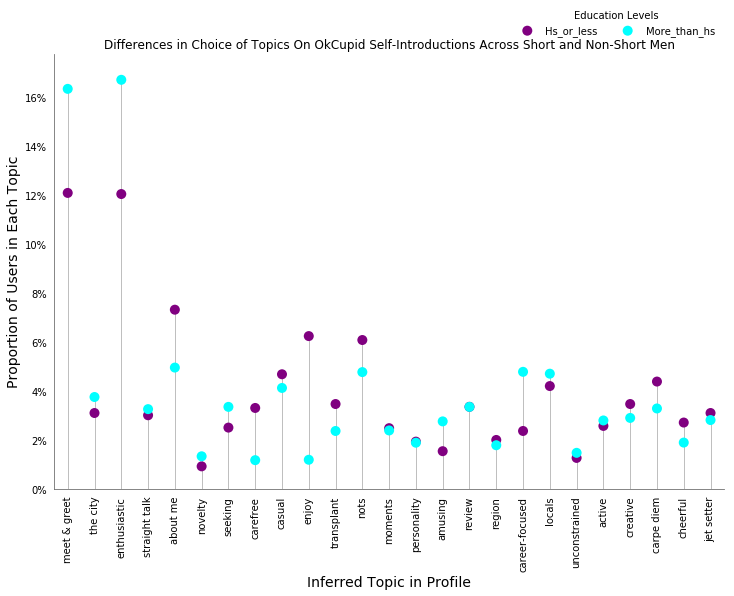

In [63]:
lollipop_chart(grouped, demog, colors=['Purple', 'Cyan'], topic_labels=labels)

In [42]:

demog = 'height_group'
subset = subset_df(df, demog, ['short', 'not_short'])
grouped = group_pct(subset, demog)
lollipop(grouped, demog, colors=['Purple', 'Cyan'], topic_labels=labels)

NameError: name 'lollipop' is not defined

### Essay 4

#### Text Representation

In [20]:
counts, tfidf, vocab = feature_vectors(df_4.essay4, specs)

In [21]:
len(vocab)

2898

#### Clustering

In [22]:
K = 25
nmf_inspect(tfidf, vocab, k_vals=[K], n_words=50)

25
Group 0:
like | music like | movies like | really | really like | stuff | food like | things | like music | books like | like movies | n't like | like food | movies | lot | stuff like | like lot | like read | kind | comedies | like good | music | good | shows like | things like | like books | think | like reading | make | different | like watch | especially | old | like kinds | feel | like eat | like types | just | people | bands | pretty | feel like | funny | probably | like cook | eat | ones | nt | lots | metal

Group 1:
men | mad | mad men | arrested | development | arrested development | bad | breaking | breaking bad | rock | 30 | 30 rock | tv | parks | sunny | wire | dexter | shows | office | curb | sunny philadelphia | 's sunny | philadelphia | rec | parks rec | community | curb enthusiasm | enthusiasm | recreation | parks recreation | 's sunny philadelphia | daily | seinfeld | tv shows | archer | shows arrested | weeds | shows arrested development | colbert | louie | lost | c

In [23]:
labels = ['like', 'TV-hits', 'enthusiastic', 'favorite-0', 'genres-movies', 'genres-music',
          'misc-0', 'TV-comedies-0', 'genres-food', 'nots', 'teen', 'everything',
          'movies-drama-0', 'time periods', 'avid', 'miscellaneous', 'music-rock',
          'movies-sci-fi', 'TV-comedies-1', 'movies-drama-1', 'kinds', 'favorite-1',
          'novelty', 'TV-drama', 'genres-books']

In [24]:
df_4['group'] = nmf_labels(tfidf, k=K)

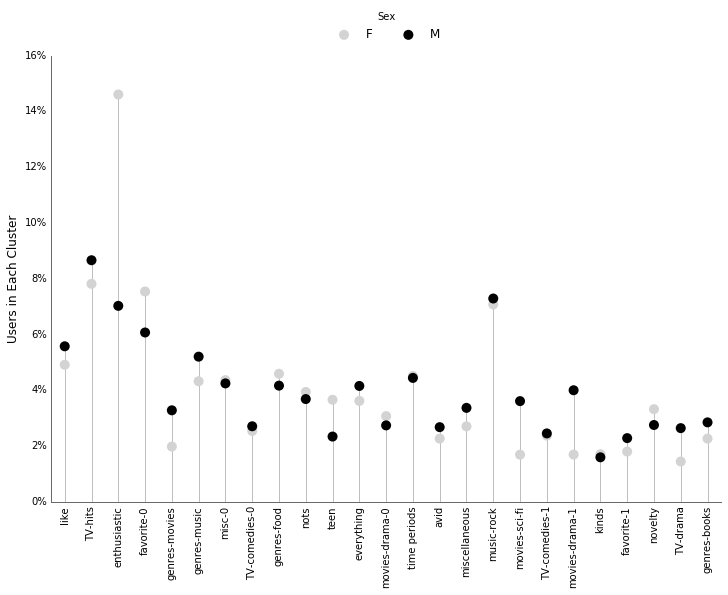

In [25]:
demog = 'sex'
subset = subset_df(df_4, demog, ['M', 'F'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, topic_labels=labels)

#### Superordinate

In [26]:
mask = df_4['group'].isin([10, 12, 17, 19])
movies = counts[np.array(mask), :]
movies = counts_by_class(movies, df_4[mask], 'sex',
                         one_vs_one=True, vals=['M', 'F'])
log_odds = log_odds_ratio(movies, vocab, use_variance=True)

In [27]:
print_terms(log_odds, 15)

star | star wars | wars | matrix | fight | park | fight club | man | dark knight | knight | pulp | godfather | trek | star trek | rings

love | girl | harry | potter | pride | prejudice | harry potter | pride prejudice | bones | girls | anatomy | jane | hunger games | grey 's | 's anatomy


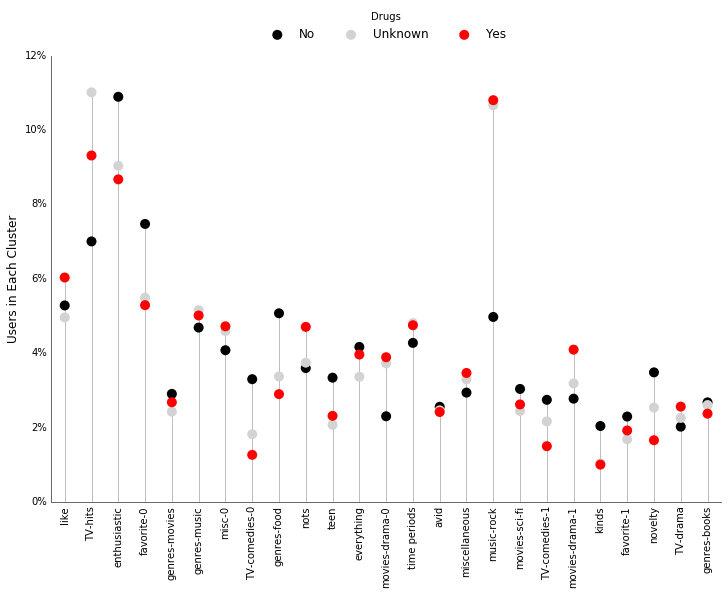

In [28]:
demog = 'drugs'
subset = subset_df(df_4, demog, ['yes', 'no', 'unknown'])
grouped = group_pct(subset, demog)
lollipop_paper(grouped, demog, colors=['Black', 'LightGray', 'Red'], topic_labels=labels)

## Predictions

In [29]:
def drug_labels(df):
    labels = []
    for i in df.index:
        if df.drugs[i] in ('no', 'unknown'):
            labels.append(0)
        elif df.drugs[i] == 'yes':
            labels.append(1)
    return labels

### Essay 4

In [30]:
# numerical drug usage labels
df_4['labels'] = drug_labels(df_4)

# split on drug usage status
drugs_yes = subset_df(df_4, 'drugs', ['yes'])
drugs_no = subset_df(df_4, 'drugs', ['no'])
drugs_unknown = subset_df(df_4, 'drugs', ['unknown'])

# balanced sample of known drug users
drugs_known_sample = pd.concat([drugs_no.sample(drugs_yes.shape[0],
                                                random_state=42),
                                drugs_yes],
                               ignore_index=True)

In [31]:
pred_4 = {'vocabulary' : vocab}
_, known, _ = feature_vectors(drugs_known_sample.essay4, pred_4)
_, unknown, _ = feature_vectors(drugs_unknown.essay4, pred_4)

In [32]:
known_train, known_test, y_train, y_test = train_test_split(known,
                                                            drugs_known_sample['labels'],
                                                            test_size=0.2, random_state=42)

In [33]:
model = LogisticRegression()
model.fit(known_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
yhat = model.predict(known_test)
print(accuracy_score(y_test, yhat))

0.680029154519


In [35]:
drugs_unknown['yhat'] = model.predict(unknown)
print(drugs_unknown.yhat.sum() / drugs_unknown.shape[0])

0.552282893071


In [36]:
drugs_unknown.groupby('group')['yhat'].mean().sort_values()

group
20    0.243902
7     0.245370
18    0.295720
8     0.312500
10    0.313008
22    0.352159
2     0.388422
3     0.436252
11    0.461153
17    0.482759
21    0.500000
24    0.501618
14    0.506849
4     0.517361
13    0.577193
23    0.585821
0     0.593537
6     0.598165
5     0.621931
9     0.626126
1     0.631418
15    0.649616
12    0.660633
19    0.661376
16    0.840190
Name: yhat, dtype: float64

### All Essays

"Tell me something I don't know. Can I predict drug usage status based on text alone? How well? Then, find the terms that are most indicative of drug usage.

In [37]:
essay_list = ['essay' + str(i) for i in range(10)]
df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9 = clean_up(df,
                                                                      essay_list,
                                                                      min_words=0)

In [38]:
# combine all essays
essays = df_0.essay0.str.cat([df_1.essay1, df_2.essay2, df_3.essay3,
                              df_4.essay4, df_5.essay5, df_6.essay6,
                              df_7.essay7, df_8.essay8, df_9.essay9], sep=' ')
df_0['essays'] = essays

df_0 = recategorize(df_0)

In [39]:
# only keep observations with more than five tokens
all_essays = df_0[df_0.essays.str.split().str.len() > 5]
all_essays.shape, df.shape

((57490, 34), (59946, 32))

In [40]:
# numerical drug usage labels
all_essays['labels'] = drug_labels(all_essays)

# split on drug usage status
drugs_yes = subset_df(all_essays, 'drugs', ['yes'])
drugs_no = subset_df(all_essays, 'drugs', ['no'])
drugs_unknown = subset_df(all_essays, 'drugs', ['unknown'])

# balanced sample of known drug users
drugs_known_sample = pd.concat([drugs_no.sample(drugs_yes.shape[0],
                                                random_state=42),
                                drugs_yes],
                               ignore_index=True)

In [41]:
# vocabulary for all essays
_, _, all_vocab = feature_vectors(all_essays.essays, specs)
print(len(all_vocab))

6835


In [42]:
pred_all = {'vocabulary' : all_vocab}
_, known, _ = feature_vectors(drugs_known_sample.essays, pred_all)
_, unknown, _ = feature_vectors(drugs_unknown.essays, pred_all)

In [43]:
known_train, known_test, y_train, y_test = train_test_split(known,
                                                            drugs_known_sample['labels'],
                                                            test_size=0.2, random_state=42)

In [44]:
model = LogisticRegression()
model.fit(known_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
yhat = model.predict(known_test)
print(accuracy_score(y_test, yhat))

0.727417302799


In [46]:
drugs_unknown['yhat'] = model.predict(unknown)

In [47]:
print(drugs_unknown.yhat.sum() / drugs_unknown.shape[0])

0.524143472861


#### Most Predictive Terms

In [48]:
token_dict = {coeff : i for i, coeff in enumerate(model.coef_[0])}

In [49]:
coefficients = model.coef_[0]
coefficients.sort()

In [50]:
import numpy as np

In [51]:
for i in range(1, 26):
    print(all_vocab[token_dict[coefficients[-i]]] + ' (' + 
          str(np.round(np.exp(coefficients[-i]), 2)) + ')', end=', ')

sex (68.96), shit (45.51), music (20.95), weed (18.46), party (15.54), beer (14.18), dubstep (13.86), fuck (12.28), drinking (11.48), smoking (11.39), partying (10.59), chill (9.45), hair (8.84), park (8.09), fucking (7.93), dj (7.9), burning (7.78), electronic (7.05), drunk (6.67), ass (6.36), reggae (6.18), robbins (5.81), dude (5.74), smoke (5.68), cat (5.5), 